Install & Import Libraries

In [2]:
!pip install -q tensorflow

import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from sklearn.metrics import classification_report, confusion_matrix

Upload & Unzip Dataset

In [5]:
from google.colab import files
files.upload()

Saving kaggle (1).json to kaggle (1) (1).json


{'kaggle (1) (1).json': b'{"username":"maddikuntladeepthi","key":"1b6cfdc71587427fab84fe7aa2a458f7"}'}

In [7]:
!mv "kaggle (1) (1).json" kaggle.json

Setup Kaggle in Colab


In [8]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Download Dataset

In [9]:
!kaggle datasets download -d emmarex/plantdisease

Dataset URL: https://www.kaggle.com/datasets/emmarex/plantdisease
License(s): unknown
 99% 653M/658M [00:01<00:00, 285MB/s]
100% 658M/658M [00:01<00:00, 391MB/s]


unzip

In [10]:
!unzip plantdisease.zip

Streaming output truncated to the last 5000 lines.
  inflating: plantvillage/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/08c033bd-fbc3-445a-88d1-1863070e52ce___YLCV_GCREC 2872.JPG  
  inflating: plantvillage/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/08dd176c-e9d9-4746-92c3-fa8dc9074347___UF.GRC_YLCV_Lab 03057.JPG  
  inflating: plantvillage/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/08f78a80-46f5-45a6-937c-4d05d61c08c2___UF.GRC_YLCV_Lab 01895.JPG  
  inflating: plantvillage/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/0903aa95-6e8a-4abd-a003-126fcd9a5493___YLCV_GCREC 2806.JPG  
  inflating: plantvillage/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/0911d416-d73d-4c2a-8e45-207a7ceb7c9a___YLCV_GCREC 2773.JPG  
  inflating: plantvillage/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/09188838-cc89-4925-94c5-d9563c4cb4bf___UF.GRC_YLCV_Lab 02974.JPG  
  inflating: plantvillage/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/0922e026-b563-438d-b9ed-74

**Explore Dataset Structure**

Check Folder Structure

In [27]:
dataset_path = "/content/PlantVillage"
IMG_SIZE = 224
BATCH_SIZE = 32
print("Total Classes:", len(os.listdir(dataset_path)))
print("\nClass Names:\n")

for class_name in os.listdir(dataset_path):
    print(class_name)

Total Classes: 15

Class Names:

Tomato_Septoria_leaf_spot
Tomato__Tomato_YellowLeaf__Curl_Virus
Tomato_Spider_mites_Two_spotted_spider_mite
Potato___Early_blight
Potato___Late_blight
Tomato_Leaf_Mold
Tomato_Early_blight
Tomato_Late_blight
Tomato_healthy
Tomato__Target_Spot
Potato___healthy
Pepper__bell___healthy
Pepper__bell___Bacterial_spot
Tomato_Bacterial_spot
Tomato__Tomato_mosaic_virus


Count Images Per Class

In [28]:
class_counts = {}

for class_name in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_name)
    class_counts[class_name] = len(os.listdir(class_path))

print("Image count per class:\n")
for key, value in class_counts.items():
    print(f"{key} : {value}")

Image count per class:

Tomato_Septoria_leaf_spot : 1771
Tomato__Tomato_YellowLeaf__Curl_Virus : 3209
Tomato_Spider_mites_Two_spotted_spider_mite : 1676
Potato___Early_blight : 1000
Potato___Late_blight : 1000
Tomato_Leaf_Mold : 952
Tomato_Early_blight : 1000
Tomato_Late_blight : 1909
Tomato_healthy : 1591
Tomato__Target_Spot : 1404
Potato___healthy : 152
Pepper__bell___healthy : 1478
Pepper__bell___Bacterial_spot : 997
Tomato_Bacterial_spot : 2127
Tomato__Tomato_mosaic_virus : 373


Plot Class Distribution

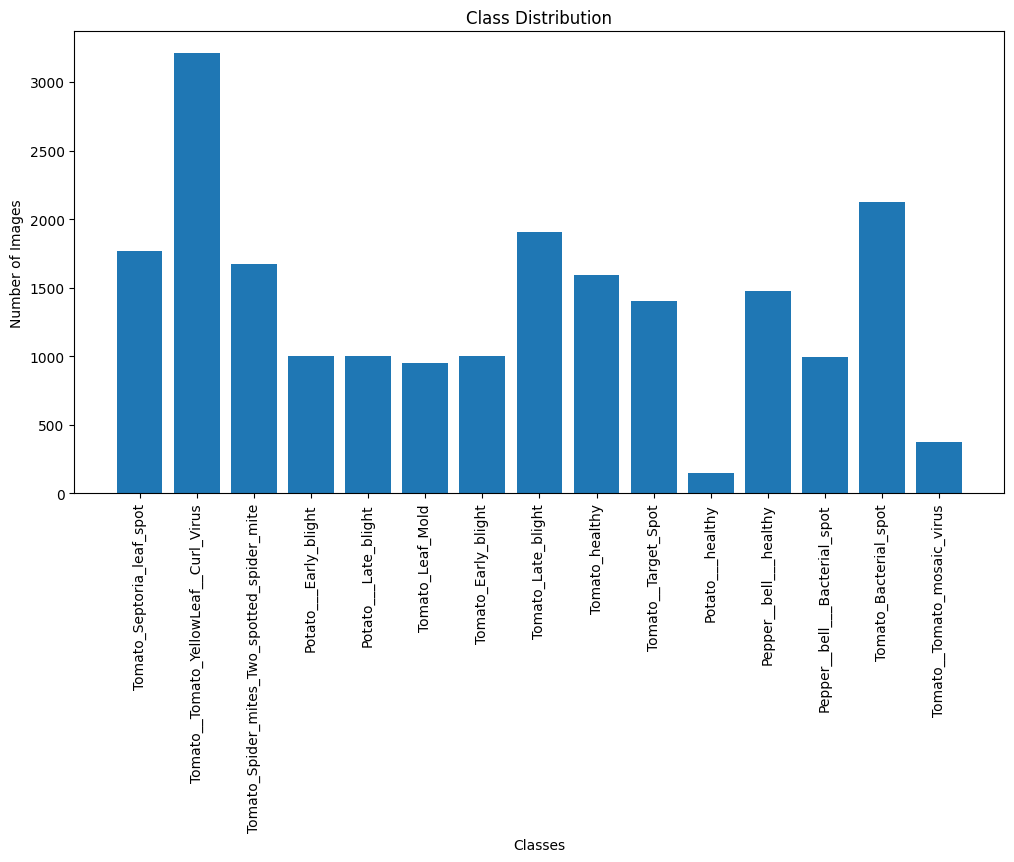

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.bar(class_counts.keys(), class_counts.values())
plt.xticks(rotation=90)
plt.title("Class Distribution")
plt.xlabel("Classes")
plt.ylabel("Number of Images")
plt.show()

Display Random Images From Different Classes

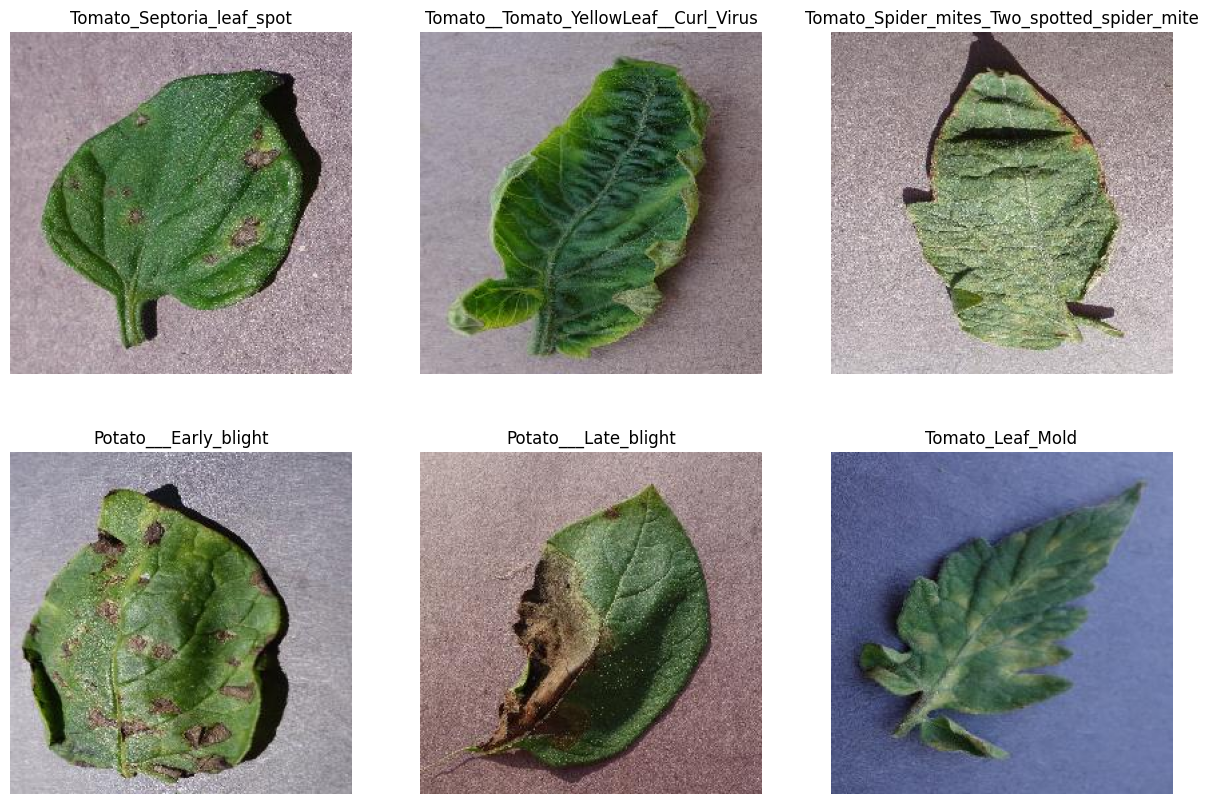

In [30]:
import random
import cv2

plt.figure(figsize=(15,10))

for i, class_name in enumerate(os.listdir(dataset_path)[:6]):
    class_path = os.path.join(dataset_path, class_name)
    image_name = random.choice(os.listdir(class_path))
    image_path = os.path.join(class_path, image_name)

    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.subplot(2,3,i+1)
    plt.imshow(img)
    plt.title(class_name)
    plt.axis("off")

plt.show()

Data Preprocessing & Augmentation

In [13]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

train_data = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

val_data = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

num_classes = train_data.num_classes
print("Total Classes:", num_classes)

Found 16516 images belonging to 15 classes.
Found 4122 images belonging to 15 classes.
Total Classes: 15


Build Transfer Learning Model

In [14]:
base_model = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

base_model.trainable = False  # Freeze initially

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 15)             │         3,855 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,589,775 (9.88 MB)

 Trainable params: 331,791 (1.27 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

Add Callbacks

In [15]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

checkpoint = ModelCheckpoint(
    "best_model.keras",
    monitor='val_accuracy',
    save_best_only=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.3,
    patience=2,
    verbose=1
)

Initial Training (Frozen Base)

In [16]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=15,
    callbacks=[early_stop, checkpoint, reduce_lr]
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
517/517 ━━━━━━━━━━━━━━━━━━━━ 273s 494ms/step - accuracy: 0.6123 - loss: 1.2402 - val_accuracy: 0.8617 - val_loss: 0.4139 - learning_rate: 0.0010
Epoch 2/15
517/517 ━━━━━━━━━━━━━━━━━━━━ 231s 446ms/step - accuracy: 0.8304 - loss: 0.5210 - val_accuracy: 0.8916 - val_loss: 0.3256 - learning_rate: 0.0010
Epoch 3/15
517/517 ━━━━━━━━━━━━━━━━━━━━ 229s 443ms/step - accuracy: 0.8459 - loss: 0.4414 - val_accuracy: 0.8959 - val_loss: 0.3000 - learning_rate: 0.0010
Epoch 4/15
517/517 ━━━━━━━━━━━━━━━━━━━━ 227s 439ms/step - accuracy: 0.8666 - loss: 0.4004 - val_accuracy: 0.9061 - val_loss: 0.2727 - learning_rate: 0.0010
Epoch 5/15
517/517 ━━━━━━━━━━━━━━━━━━━━ 225s 436ms/step - accuracy: 0.8790 - loss: 0.3610 - val_accuracy: 0.8969 - val_loss: 0.2901 - learning_rate: 0.0010
Epoch 6/15
517/517 ━━━━━━━━━━━━━━━━━━━━ 226s 438ms/step - accuracy: 0.8800 - loss: 0.3535 - val_accuracy: 0.9105 - val_loss: 0.2550 - learning_rate: 0.0010
Epoch 7/15
517/517 ━━━━━━━━━━━━━━━━━━━━ 227s 440ms/step - accura

Fine-Tuning

In [17]:
print("Starting Fine-Tuning...")

base_model.trainable = True

# Freeze first layers, train last 20 layers
for layer in base_model.layers[:-20]:
    layer.trainable = False

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_fine = model.fit(
    train_data,
    validation_data=val_data,
    epochs=5
)

Starting Fine-Tuning...
Epoch 1/5
517/517 ━━━━━━━━━━━━━━━━━━━━ 257s 471ms/step - accuracy: 0.8176 - loss: 0.6363 - val_accuracy: 0.8367 - val_loss: 0.7468
Epoch 2/5
517/517 ━━━━━━━━━━━━━━━━━━━━ 228s 441ms/step - accuracy: 0.9203 - loss: 0.2381 - val_accuracy: 0.8879 - val_loss: 0.4524
Epoch 3/5
517/517 ━━━━━━━━━━━━━━━━━━━━ 229s 443ms/step - accuracy: 0.9356 - loss: 0.2007 - val_accuracy: 0.9231 - val_loss: 0.2944
Epoch 4/5
517/517 ━━━━━━━━━━━━━━━━━━━━ 229s 443ms/step - accuracy: 0.9463 - loss: 0.1575 - val_accuracy: 0.9427 - val_loss: 0.1865
Epoch 5/5
517/517 ━━━━━━━━━━━━━━━━━━━━ 228s 441ms/step - accuracy: 0.9550 - loss: 0.1335 - val_accuracy: 0.9563 - val_loss: 0.1360


Plot Accuracy & Loss

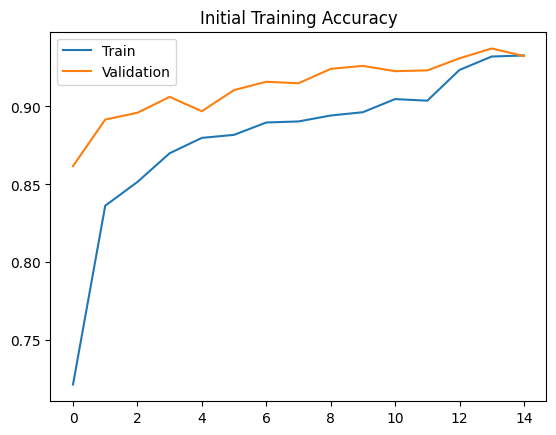

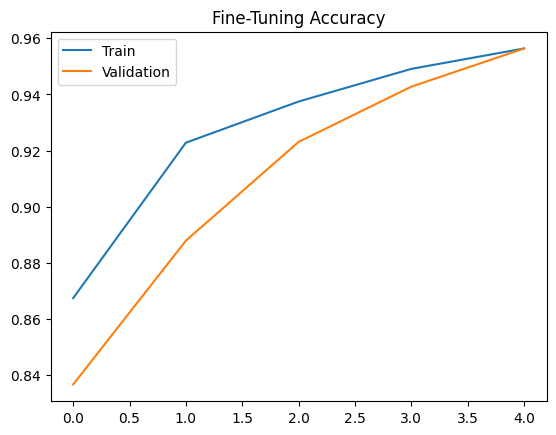

In [18]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Initial Training Accuracy")
plt.legend(["Train", "Validation"])
plt.show()

plt.plot(history_fine.history['accuracy'])
plt.plot(history_fine.history['val_accuracy'])
plt.title("Fine-Tuning Accuracy")
plt.legend(["Train", "Validation"])
plt.show()

Final Evaluation

In [19]:
loss, acc = model.evaluate(val_data)
print("Final Validation Accuracy:", acc)

129/129 ━━━━━━━━━━━━━━━━━━━━ 45s 346ms/step - accuracy: 0.9600 - loss: 0.1355
Final Validation Accuracy: 0.9536632895469666


Confusion Matrix & Report

In [20]:
val_data.reset()
pred = model.predict(val_data)
pred_classes = np.argmax(pred, axis=1)

true_classes = val_data.classes
class_labels = list(val_data.class_indices.keys())

print(classification_report(true_classes, pred_classes, target_names=class_labels))

129/129 ━━━━━━━━━━━━━━━━━━━━ 54s 388ms/step
                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.02      0.03      0.02       199
                     Pepper__bell___healthy       0.06      0.06      0.06       295
                      Potato___Early_blight       0.05      0.05      0.05       200
                       Potato___Late_blight       0.06      0.06      0.06       200
                           Potato___healthy       0.00      0.00      0.00        30
                      Tomato_Bacterial_spot       0.08      0.08      0.08       425
                        Tomato_Early_blight       0.05      0.06      0.05       200
                         Tomato_Late_blight       0.10      0.09      0.09       381
                           Tomato_Leaf_Mold       0.08      0.08      0.08       190
                  Tomato_Septoria_leaf_spot       0.08      0.09      0.09       354
Tomato_Spider_mites_

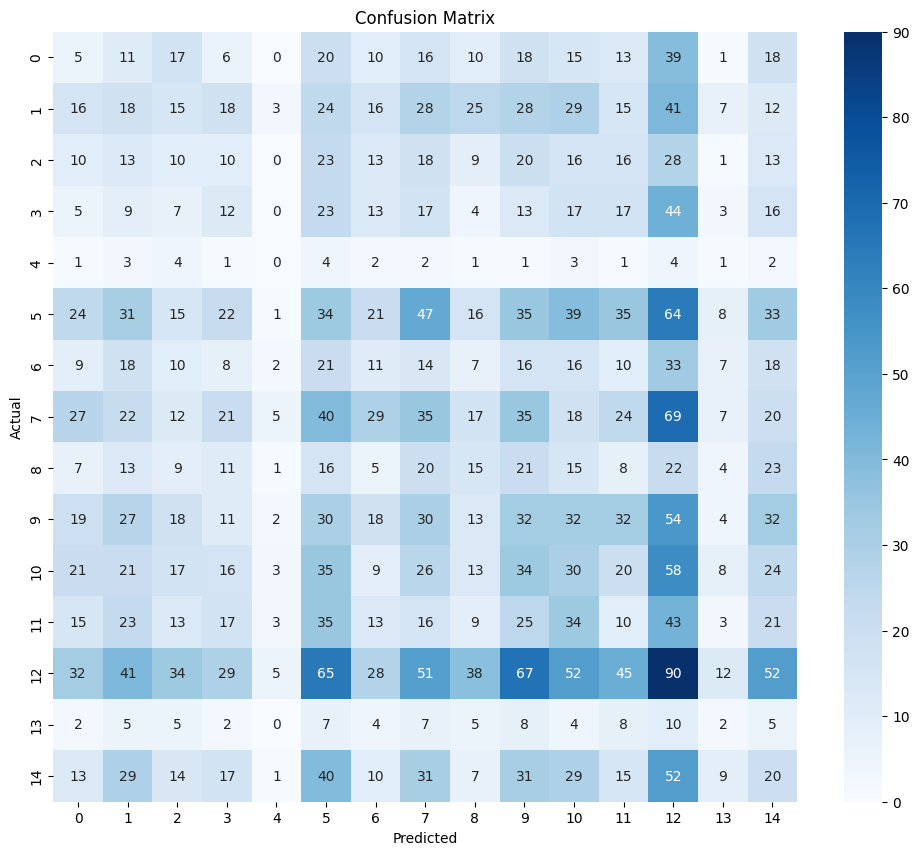

In [21]:
cm = confusion_matrix(true_classes, pred_classes)

plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

Save Final Model

In [22]:
model.save("plant_disease_final_model.keras")

Predict on New Image

In [25]:
from google.colab import files
files.upload()

Saving test.jpg to test (1).jpg


{'test (1).jpg': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00\x84\x00\t\x06\x07\x08\x07\x06\t\x08\x07\x08\n\n\t\x0b\r\x16\x0f\r\x0c\x0c\r\x1b\x14\x15\x10\x16 \x1d"" \x1d\x1f\x1f$(4,$&1\'\x1f\x1f-=-157:::#+?D?8C49:7\x01\n\n\n\r\x0c\r\x1a\x0f\x0f\x1a7%\x1f%77777777777777777777777777777777777777777777777777\xff\xc0\x00\x11\x08\x00\x94\x00\xc1\x03\x01\x11\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1b\x00\x00\x03\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x04\x05\x06\x03\x07\x02\x01\x00\xff\xc4\x00B\x10\x00\x02\x01\x03\x03\x01\x05\x05\x06\x04\x03\x07\x04\x03\x00\x00\x01\x02\x03\x00\x04\x11\x05\x12!1\x06\x13AQa\x14"q\x81\x91#2\xa1\xb1\xc1\xf0\x15BR\xd1Sb\xe1\x16CTr\x93\xc2\xf1\x07s\x82\x92$34\xff\xc4\x00\x1a\x01\x00\x02\x03\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x03\x04\x01\x02\x05\x06\x00\xff\xc4\x004\x11\x00\x02\x02\x01\x03\x02\x04\x03\x07\x04\x02\x03\x00\x00\x00\x00\x01\x02\x00\x03\x11\x04\x12!1A\x05\x13"Qaq\xf0\x142\x81\x91\xa

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
Predicted Disease: Pepper__bell___Bacterial_spot
Confidence: 99.60%


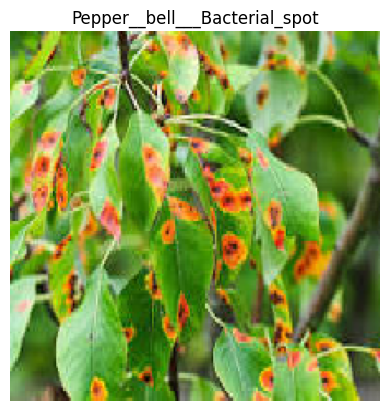

In [26]:
from tensorflow.keras.preprocessing import image

img_path = "test.jpg"  # change name
img = image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
img_array = image.img_to_array(img)
img_array = preprocess_input(img_array)
img_array = np.expand_dims(img_array, axis=0)

prediction = model.predict(img_array)

predicted_index = np.argmax(prediction)
confidence = np.max(prediction) * 100

predicted_class = class_labels[predicted_index]

print("Predicted Disease:", predicted_class)
print("Confidence: {:.2f}%".format(confidence))

plt.imshow(img)
plt.axis("off")
plt.title(predicted_class)
plt.show()